In [1]:
from SMOOTH import *
from BLOCKS import *
from MIXED import *
from KERNEL import *

import matplotlib.pyplot as plt

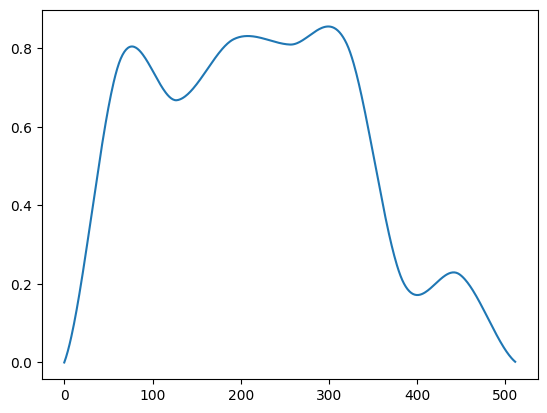

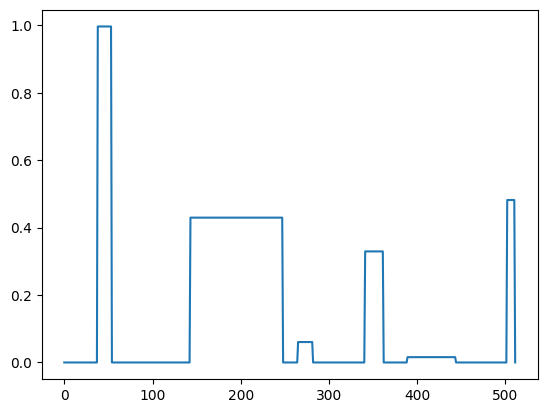

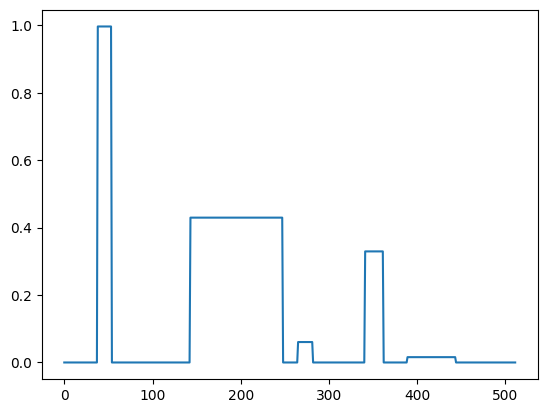

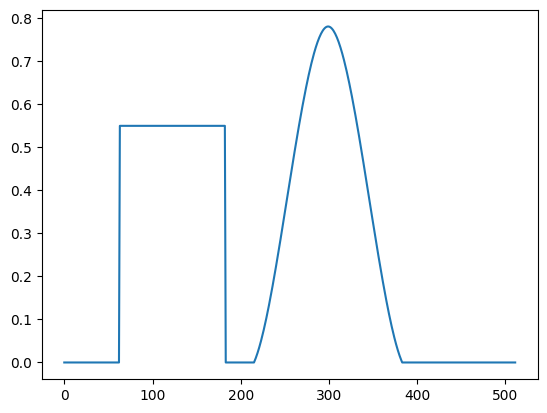

In [2]:
smooth = generate_smooth_signal()
plt.plot(smooth)
plt.show()

blocked = generate_block_signal()
plt.plot(blocked)
plt.show()
blocked[475:] = 0
plt.plot(blocked)
plt.show()

combined = generated_combined_signal()
plt.plot(combined)
plt.show()

In [3]:
#FILE = "presentation_signals.csv"
# sigs = open(FILE, 'r')
# This is here as a way to reinitialize with good signals.
"""sigs = open(FILE, 'w')
for i in smooth:
    sigs.write(f"{i},")
sigs.write('\n')
for i in blocked:
    sigs.write(f"{i},")
sigs.write('\n')
for i in combined:
    sigs.write(f"{i},")
sigs.close()"""

'sigs = open(FILE, \'w\')\nfor i in smooth:\n    sigs.write(f"{i},")\nsigs.write(\'\n\')\nfor i in blocked:\n    sigs.write(f"{i},")\nsigs.write(\'\n\')\nfor i in combined:\n    sigs.write(f"{i},")\nsigs.close()'

In [4]:
FILE = "presentation_signals.csv"
sigs = open(FILE, 'r')
smooth = sigs.readline()
blocked = sigs.readline()
combined = sigs.readline()
sigs.close()
smooth = smooth.split(',')
blocked = blocked.split(',')
combined = combined.split(',')
smooth = [float(i) for i in smooth]
blocked = [float(i) for i in blocked]
combined = [float(i) for i in combined]

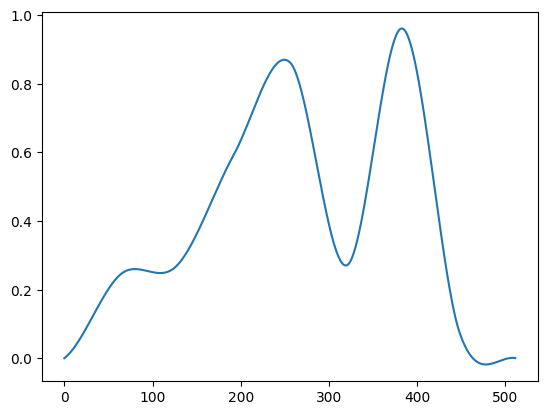

In [5]:
plt.plot(smooth)
plt.show()
#plt.savefig('./figures/smooth.png', dpi=300)

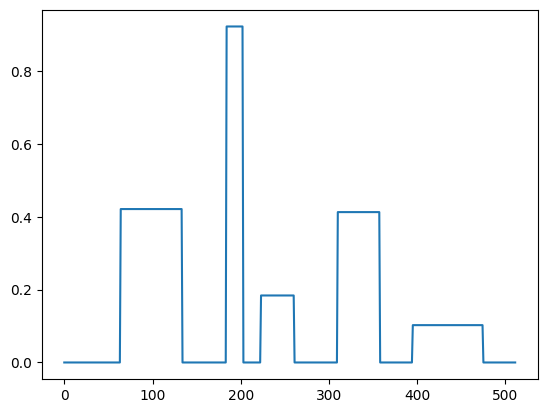

In [6]:
plt.plot(blocked)
plt.show()
#plt.savefig('./figures/blocked.png', dpi=300)

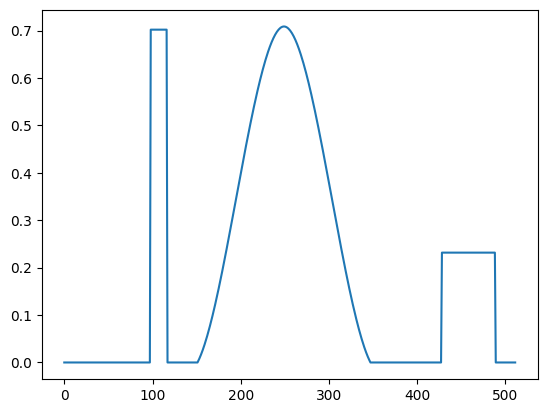

In [7]:
plt.plot(combined)
plt.show()
#plt.savefig('./figures/combined.png', dpi=300)

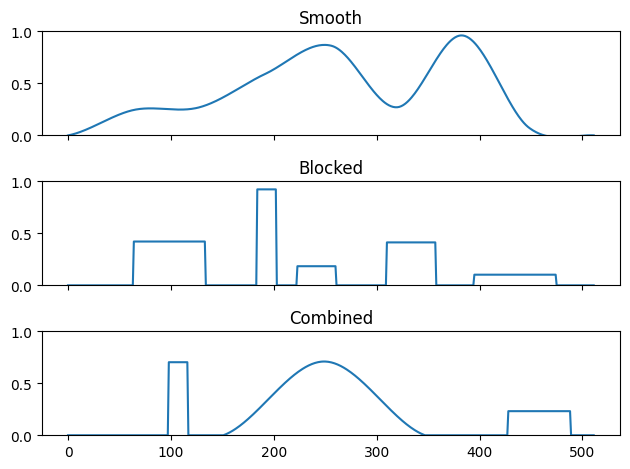

In [8]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex='col')
ax0.plot(smooth)
ax0.set_ylim(0,1)
ax0.set_title("Smooth")

ax1.plot(blocked)
ax1.set_ylim(0,1)
ax1.set_title("Blocked")

ax2.plot(combined)
ax2.set_ylim(0,1)
ax2.set_title("Combined")

plt.tight_layout()
plt.show()
#plt.savefig('./figures/subplots.png', dpi=300)

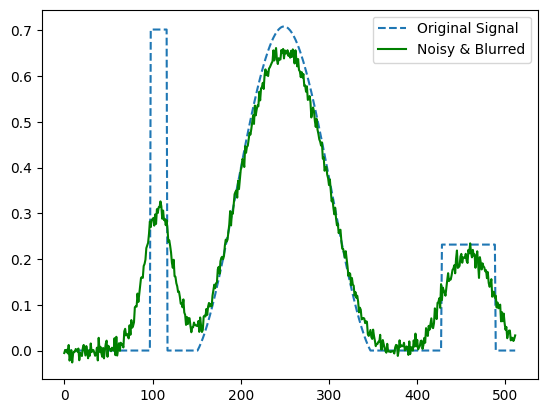

In [9]:
from BLUR import *
from KERNEL import *

x = np.asarray(combined)
A = kernel(len(combined), 16)
blurred = blur(x, A, True, 0.012)

plt.plot(x, '--')
plt.plot(blurred, 'g')
plt.legend(["Original Signal", "Noisy & Blurred"])
plt.show()
#plt.savefig('./figures/blurred.png', dpi=300)

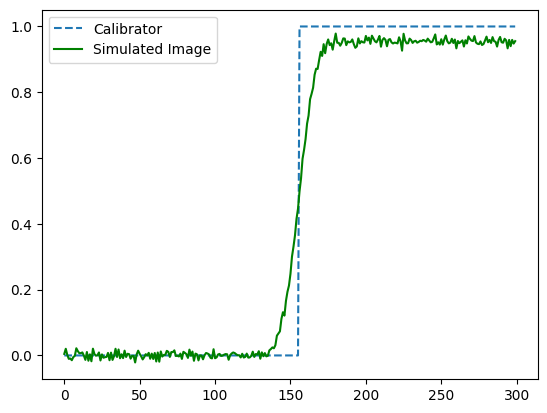

In [10]:
calib_x = []
for i in range(512):
    if i < 256:
        calib_x.append(0.)
    else:
        calib_x.append(1.)
calib_x = np.asarray(calib_x).reshape(len(calib_x), 1)
calib_A = kernel(calib_x.shape[0], 9)
calib_blurred = blur(calib_x, calib_A, True, 0.01)

plt.plot(calib_x[100:400], '--')
plt.plot(calib_blurred[100:400], 'g')
plt.legend(["Calibrator", "Simulated Image"])
plt.show()
#plt.savefig('./figures/blurrededge.png', dpi=300)

In [11]:
from statistics import mean
from math import exp
from scipy.special import erf

def diff(sig, s):
    d = np.zeros(s)
    for i in range(s):
        if i == 0 or i == s-1:
            d[i] = 0
        else:
            d[i] = (sig[i+1] - sig[i-1]) / 2.
    return d

def normalize_diff(sig):
    s = sum(sig)*2
    return [i / s for i in sig]

def normalize_edge(sig):
    l = len(sig)
    v = sig[l-l//8:]
    p = mean(v)
    return [i / p for i in sig]

def find_index(val, ls):
    i = 0
    for j in ls:
        if j == val:
            return i
        else:
            i += 1
    return 0

# Define curve functions to fit

def logistic(k, le):
    y = []
    x0 = le // 2
    for x in range(le):
        v = 1 / (1 + exp(-k * (x - x0)))
        y.append(v)
    return y

def use_erf(a, le):
    y = []
    x0 = le // 2
    for x in range(le):
        y.append(0.5 * (1 + erf(a*(x-x0))))
    return y

def find_mse(orig, new):
    return mean(abs(a - b) for a, b in zip(orig, new))

In [12]:
cropped_x = calib_blurred[150:512-150]
cropped_x = cropped_x.transpose()
cropped_x = cropped_x[0]
norm_x = normalize_edge(cropped_x)
n = 512
k = [np.random.random() for i in range(n)]
mses = [find_mse(norm_x, use_erf(term, len(norm_x))) for term in k]
m = find_index(min(mses), mses)

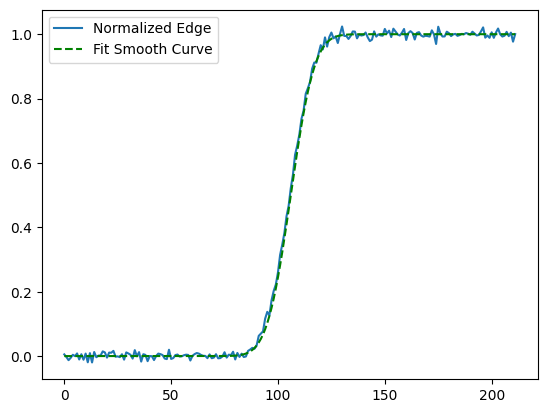

In [13]:
plt.plot(norm_x)
plt.plot(use_erf(k[m], len(norm_x)), 'g--')
plt.legend(["Normalized Edge", "Fit Smooth Curve"])
plt.show()
#plt.savefig('./figures/fitcurve.png')

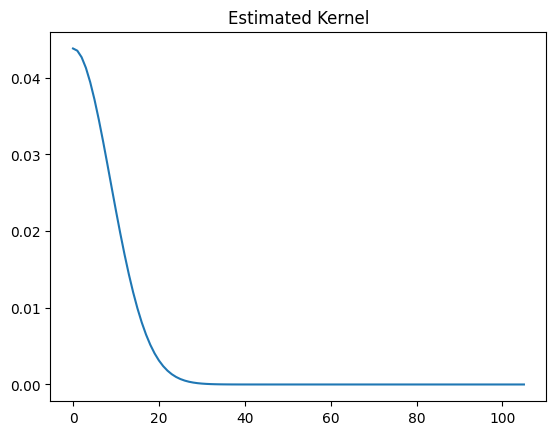

In [14]:
diff_calib_x = diff(use_erf(k[m], len(norm_x)), len(norm_x))
diff_calib_x = normalize_diff(diff_calib_x[len(norm_x)//2:])
plt.plot(diff_calib_x)
plt.title("Estimated Kernel")
plt.show()
#plt.savefig('./figures/kernel.png', dpi=300)

In [15]:
print(sum(diff_calib_x))

0.5000000000000003


In [16]:
A = generateBlurMatrix(len(calib_x), diff_calib_x)

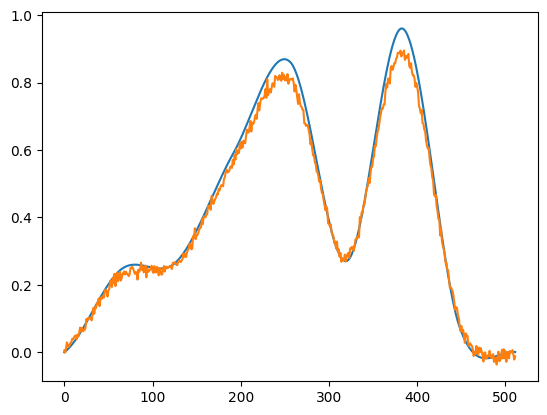

In [17]:
test = blur(np.array(smooth).reshape((512, 1)), calib_A, True, 0.01)
plt.plot(smooth)
plt.plot(test)
plt.show()

In [18]:
from TKV_REG import *
from GCV import *

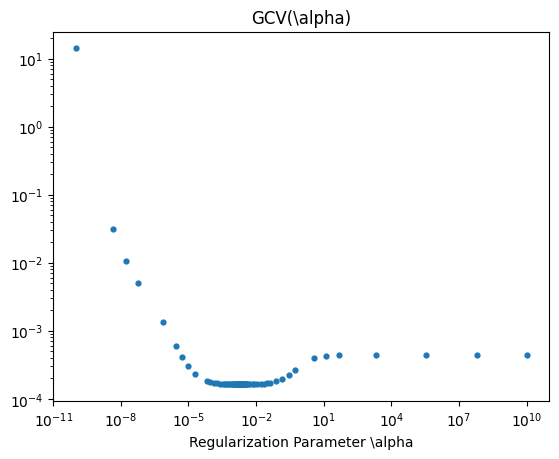

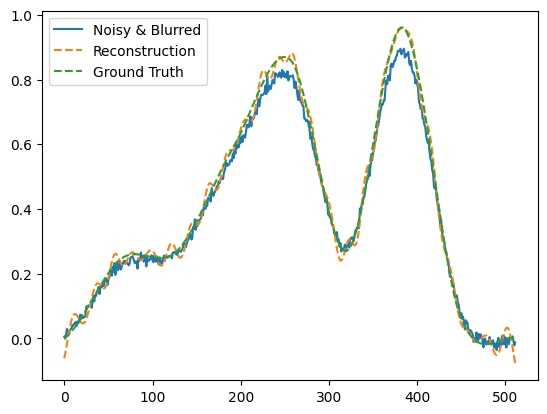

In [19]:
toggleDebug(1)
reconstructed, gcv = run_gcv(A, test, tkv_regularize, 12)

plt.plot(test)
plt.plot(reconstructed, '--')
plt.plot(smooth, '--')
plt.legend(["Noisy & Blurred", "Reconstruction", "Ground Truth"])
plt.show()